# Knowledge Distillation

In [1]:
#General Imports
import numpy as np

#All Imports for Tensorflow/Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

## Summary:
### Terminology that we use throughout this section:
The "Teacher" network is a large and complex neural network that takes a long time to train

The "Student" network is a small neural network that learns information from the output of the "Teacher" network.  This is the network we are attempting to optimize throughout the distillation process because it has far less parameters leading to a reasonable execution time for production products (such as real time object recognition camera systems)

The "Control" network is a small neural network that has the exact same architecture as the student network.  However we train this network independently so it isn't learning anything from the teacher model and we can use it as a baseline to see if this knowledge distillation process is really making a difference!

### The general algorithm that we follow for Knowledge Distillation:
1. Define the Teacher and Student Neural Network models (the teacher model should be a lot larger and have more parameters to train
2. Train the teacher model using ordinary methods (this will be time consuming most likely depending on how large the teacher model is
3. Train the student network model using the "blurred" probability classification outputs of the teacher model.  We achieve this blurring by dividing the logits by some temperature value.  Note that THE HIGHER THE TEMPERATURE VALUE THE SOFTER THE PROBABILITY DISTRIBUTION IS OVER THE CLASSES!
4. We train the student network using this high temperature value 
5. We use a temperature value of 1 again when evaluating the student model
6. We train a control network (same architecture as the student) using ordinary training techniques to get a comparison

### Why do we use Knowledge Distillation?:
-We use knowledge distillation in order to get better results using smaller networks that take far less time and computing power to run! These small and high performing networks are ideal for making marketable products that work well in real time!

### Papers and Sources Cited that Helped with Ideas and Implementations:
-https://cs230.stanford.edu/files_winter_2018/projects/6940224.pdf

-https://machinelearningmastery.com/cross-entropy-for-machine-learning/

-https://keras.io/examples/vision/knowledge_distillation/

## Part 1: General Distillation Implementation and Baseline Results

First we load the MNIST training set and normalize the pixel values by dividing by 255

In [2]:
#Below We load in the mnist dataset that we have used in previous weeks so we don't 
#do much preprocessing or EDA this week!
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Normalizing our data
x_train = x_train.astype("float32") / 255.0
x_train = np.reshape(x_train, (-1, 28, 28, 1))

x_test = x_test.astype("float32") / 255.0
x_test = np.reshape(x_test, (-1, 28, 28, 1))

Next we create the model architectures for the Large Neural Network (teacher model), the Small Neural Network (student model), and a copy of the Small Neural Network (control model).
Then at the end we create copies of the student model for later when we are optimizing the temperature and and alpha in part 2.

In [3]:
# Create the teacher network model
teacher = keras.Sequential(
    [
        keras.Input(shape=(28, 28, 1)),
        layers.Conv2D(256, (3, 3), strides=(2, 2), padding="same"),            #Note the large size of this layer
        layers.LeakyReLU(alpha=0.2),
        layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"),    #And of this layer!
        layers.Conv2D(512, (3, 3), strides=(2, 2), padding="same"),
        layers.Flatten(),
        layers.Dense(10),
    ],
    name="teacher",
)

# Create the student
student = keras.Sequential(
    [
        layers.Input(shape=(28, 28, 1)),
        layers.Conv2D(16, (3, 3), strides=(2, 2), padding="same"),      #Note that this student network has smaller  
        layers.LeakyReLU(alpha=0.2),
        layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"),   
        layers.Conv2D(32, (3, 3), strides=(2, 2), padding="same"),      # layers in these parts!!
        layers.Flatten(),
        layers.Dense(10),
    ],
    name="student",
)

#Creating a copy of the student model to be the control model!
controlModel = keras.models.clone_model(student)

#Here we are creating copies of the student model for later when we are optimizing temperature and and alpha
studentDict = {}
numStudents = 10
for i in range(numStudents):
    currString = 'student'+str(i)
    studentDict[currString] = keras.models.clone_model(student)

print(studentDict)


2021-10-06 09:41:25.913131: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


{'student0': <tensorflow.python.keras.engine.sequential.Sequential object at 0x7ffc49c78ee0>, 'student1': <tensorflow.python.keras.engine.sequential.Sequential object at 0x7ffc56395520>, 'student2': <tensorflow.python.keras.engine.sequential.Sequential object at 0x7ffc563b4340>, 'student3': <tensorflow.python.keras.engine.sequential.Sequential object at 0x7ffc563b83d0>, 'student4': <tensorflow.python.keras.engine.sequential.Sequential object at 0x7ffc563d1580>, 'student5': <tensorflow.python.keras.engine.sequential.Sequential object at 0x7ffc563e83a0>, 'student6': <tensorflow.python.keras.engine.sequential.Sequential object at 0x7ffc563fbaf0>, 'student7': <tensorflow.python.keras.engine.sequential.Sequential object at 0x7ffc56454bb0>, 'student8': <tensorflow.python.keras.engine.sequential.Sequential object at 0x7ffc564630d0>, 'student9': <tensorflow.python.keras.engine.sequential.Sequential object at 0x7ffc56485df0>}


Next we train the large teaching model in the usual way since we assume that this model is fixed.  It is important to note that this model takes a long time to train nearly 2.5 minutes per epoch!!(this is what we are trying to eliminate)

In [4]:
# Train teacher model in the basic way 
teacher.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

# Train and evaluate teacher on data.
teacher.fit(x_train, y_train, epochs=5)
teacher.evaluate(x_test, y_test)

2021-10-06 09:41:26.836196: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/5
1875/1875 [==============================] - 162s 86ms/step - loss: 0.1428 - sparse_categorical_accuracy: 0.9568
Epoch 2/5
1875/1875 [==============================] - 161s 86ms/step - loss: 0.0918 - sparse_categorical_accuracy: 0.9720
Epoch 3/5
1875/1875 [==============================] - 171s 91ms/step - loss: 0.0812 - sparse_categorical_accuracy: 0.9763
Epoch 4/5
1875/1875 [==============================] - 171s 91ms/step - loss: 0.0756 - sparse_categorical_accuracy: 0.9790
Epoch 5/5
313/313 [==============================] - 5s 15ms/step - loss: 0.0834 - sparse_categorical_accuracy: 0.9777


[0.08337046951055527, 0.9776999950408936]

Below is our class implementation of the knowledge distillation algorithm that was presented in the slides.  We will input our student and our trained teacher into this class in order to make our distilled student model (where the student model is using the smoothed probability classification output of the teacher model in order to learn from it!)

In [5]:
class distillationModel(keras.Model):
    def __init__(self, student, teacher):
        super(distillationModel, self).__init__()
        self.teacher = teacher
        self.student = student

    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
        alpha=0.1,
        temperature=10,
    ):
        super(distillationModel, self).compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    #This method does a forward pass of the "student" and "teacher".  Only student weights are updated though
    #thus we only calculate gradients for the "student"
    def train_step(self, data):
        x, y = data
        teacher_predictions = self.teacher(x, training=False)  #"teachers forward pass"

        with tf.GradientTape() as tape:
            student_predictions = self.student(x, training=True)  #"students forward pass"
            student_loss = self.student_loss_fn(y, student_predictions)  #student and distillation losses
            distillation_loss = self.distillation_loss_fn(
                tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
                tf.nn.softmax(student_predictions / self.temperature, axis=1),
            )
            loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss
        trainable_vars = self.student.trainable_variables     #student gradient
        gradients = tape.gradient(loss, trainable_vars)

        self.optimizer.apply_gradients(zip(gradients, trainable_vars)) #updating the weights with the gradient applied
        
        self.compiled_metrics.update_state(y, student_predictions)  #updating the metrics

        results = {m.name: m.result() for m in self.metrics}       #returning the performance currently in a dictionary
        results.update(
            {"student_loss": student_loss, "distillation_loss": distillation_loss}
        )
        return results

    #In this function the student model is evaluated on the current dataset
    def test_step(self, data):
        x, y = data
        y_prediction = self.student(x, training=False) 
        student_loss = self.student_loss_fn(y, y_prediction)   
        self.compiled_metrics.update_state(y, y_prediction)
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        return results

-Next we create the definition of our distillation (student model) using the class definition above and we set our hyperparameters to be temperature=10 and alpha=0.1

-Looking at our results we can see that this distillation model achieved 97.53% sparse categorical accuracy on the MNIST dataset.  This is great because this network was so much smaller that it took only a fraction of the time to train and run (looking below we can see it was roughly 46 seconds per epoch as opposed to the 2.5 minutes for the large teacher network)

-Also it achieved this level of accuracy after only 3 epochs instead of 5!

In [6]:
# Initialize and compile distiller
distiller = distillationModel(student=student, teacher=teacher)
distiller.compile(
    optimizer=keras.optimizers.Adam(),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
    student_loss_fn=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    distillation_loss_fn=keras.losses.KLDivergence(),
    alpha=0.1,
    temperature=10,
)

# Distill teacher to student
distiller.fit(x_train, y_train, epochs=3)

# Evaluate student on test dataset
distiller.evaluate(x_test, y_test)

Epoch 1/3
1875/1875 [==============================] - 46s 24ms/step - sparse_categorical_accuracy: 0.9136 - student_loss: 0.3650 - distillation_loss: 0.1035
Epoch 2/3
1875/1875 [==============================] - 48s 25ms/step - sparse_categorical_accuracy: 0.9705 - student_loss: 0.1126 - distillation_loss: 0.0273
Epoch 3/3
313/313 [==============================] - 1s 2ms/step - sparse_categorical_accuracy: 0.9753 - student_loss: 0.0917


[0.9753000140190125, 5.8156940212938935e-05]

Finally, taking a look at the control models results below we were initially very surprised by the results! This is because the control small model is actually able to achieve 97.8% accuracy after only 3 epochs each taking 8 seconds to run which is better than the distillation model.

-However thinking about it more we remembered the temperature and alpha hyperparameters that the distillation uses and realized that we may have not picked the optimal values (10 and 0.1) for these.  

-This leads us into part 2 where we try to tune the temperature an alpha hyperparameters to improve the distillation model to the point of outperforming the control model!

In [7]:
# Train Control Model Using the Student Clone from Earlier
controlModel.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

# Train and evaluate student trained from scratch.
controlModel.fit(x_train, y_train, epochs=3)
controlModel.evaluate(x_test, y_test)

Epoch 1/3
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2418 - sparse_categorical_accuracy: 0.9277
Epoch 2/3
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0923 - sparse_categorical_accuracy: 0.9720
Epoch 3/3
313/313 [==============================] - 0s 1ms/step - loss: 0.0655 - sparse_categorical_accuracy: 0.9782


[0.06546541303396225, 0.9782000184059143]

## Part 2: Optimizing the Values of Temperature and Alpha

In this section we will now attempt to find the optimal values for the temperature and alpha parameter in the previous problem that maximize the accuracy performance of our small (student) neural network

In [8]:
alphaArr = [0.05,0.5,0.95]
numAlphas = len(alphaArr)
alphaTempArr = np.zeros((numAlphas,numStudents))
tempArr = []

accuracyArr = []
for i in range(numAlphas):
    for j in range(numStudents):
        currString = 'student'+str(i)
        currDistiller = distillationModel(student=studentDict[currString], teacher=teacher)
        currDistiller.compile(
            optimizer=keras.optimizers.Adam(),
            metrics=[keras.metrics.SparseCategoricalAccuracy()],
            student_loss_fn=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            distillation_loss_fn=keras.losses.KLDivergence(),
            alpha=0.1,
            temperature=((j+1)*2),
        )
            # Distill teacher to student
        currDistiller.fit(x_train, y_train, epochs=3)

        # Evaluate student on test dataset
        currEval = currDistiller.evaluate(x_test, y_test)
        print(f"Current Distillation evaluation is: {currEval}")

        #Appending current temperature to temperature array
        tempArr.append((j+1)*2)
        
        alphaTempArr[i,j] = currEval[0]

Epoch 1/3
1875/1875 [==============================] - 47s 25ms/step - sparse_categorical_accuracy: 0.9221 - student_loss: 0.2820 - distillation_loss: 0.2228
Epoch 2/3
1875/1875 [==============================] - 48s 25ms/step - sparse_categorical_accuracy: 0.9696 - student_loss: 0.1108 - distillation_loss: 0.0654
Epoch 3/3
313/313 [==============================] - 1s 2ms/step - sparse_categorical_accuracy: 0.9759 - student_loss: 0.0859
Current Distillation evaluation is: [0.9758999943733215, 0.00019955712195951492]
Epoch 1/3
1875/1875 [==============================] - 46s 24ms/step - sparse_categorical_accuracy: 0.9773 - student_loss: 0.0855 - distillation_loss: 0.0331
Epoch 2/3
1875/1875 [==============================] - 47s 25ms/step - sparse_categorical_accuracy: 0.9794 - student_loss: 0.0759 - distillation_loss: 0.0262
Epoch 3/3
313/313 [==============================] - 1s 2ms/step - sparse_categorical_accuracy: 0.9773 - student_loss: 0.0857
Current Distillation evaluation is:

In [9]:
print("Below is the results of each of the distillation 'students' after 3 epochs of training in an array")
print(alphaTempArr)

plzzz
[[0.97589999 0.97729999 0.97869998 0.9795     0.98110002 0.97960001
  0.98189998 0.98259997 0.98280001 0.98290002]
 [0.97939998 0.98049998 0.98009998 0.98140001 0.98280001 0.98369998
  0.9831     0.98320001 0.98140001 0.98220003]
 [0.97409999 0.98030001 0.97960001 0.98220003 0.9831     0.9835
  0.98180002 0.98210001 0.98339999 0.98379999]]


In the cell below we visualize the results using a heatmap produced by seaborn.  We can see how the different distillation "student" models do as we vary the input parameters for the temperature and alpha.

The largest thing to note is the really light square in the middle where the temperature parameter was 12 and the alpha was 0.5.  This small network distillation model had a testing accuracy of over 98.2% after just 3 epochs of learning from the teacher model!  This is much better than the small network model training on its own and even the results from the teacher model.  

From what we have learned we believe that these distillation models are able to perform so well with so little training because they learn things parts of the probability distribution of the teacher model where it is unsure (where it might be predicting a 5% probability that an image is a 5 and a 3% probability that the image is a 2) as well as the correct parts of the teachers probability distribution (for example when it is predicting 90% that an image is classified as a 7 or something)

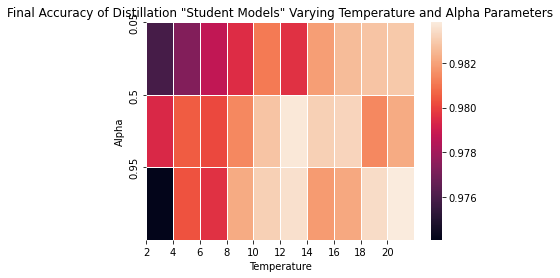

In [21]:
import seaborn as sns

ax = sns.heatmap(alphaTempArr, linewidth=0.5)
ax.set_title('Final Accuracy of Distillation "Student Models" Varying Temperature and Alpha Parameters')
ax.set(xlabel='Temperature', ylabel='Alpha')
ax.set_xticks(range(10))
#ax.set_xticklabels('2','4','6','8','10','12','14','16','18','20')
temps = ['2','4','6','8','10','12','14','16','18','20']
ax.set_xticks(np.arange(len(temps)))
ax.set_xticklabels(temps)
alphas = ['0.05','0.5','0.95']
ax.set_yticks(np.arange(len(alphas)))
ax.set_yticklabels(alphas)
plt.show()

## Part 3: Testing Generalizability to Cifar-10 Dataset

In this section we test how generalizable the distillation model we just found is!  In order to do this we use the Cifar10 dataset instead of the MNIST dataset.  Then we create a distillation model using the hyperparameters of 12 for temperature and 0.5 for alpha that we found worked so well on the MNIST dataset.

Then our objective is to compare the results of this distillation model to the results of training a normal small network to see if these parameters that we tuned on a different dataset generalize well, or whether it is necessary to go through the hyperparameter tuning process again.

In [23]:
# Importing the cifar10 dataset now
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

# Normalize data
x_train = x_train.astype("float32") / 255.0
x_train = np.reshape(x_train, (-1, 32, 32, 3))

x_test = x_test.astype("float32") / 255.0
x_test = np.reshape(x_test, (-1, 32, 32, 3))

In [24]:
# Create the teacher
teacher = keras.Sequential(
    [
        keras.Input(shape=(32, 32, 3)),
        layers.Conv2D(256, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"),
        layers.Conv2D(512, (3, 3), strides=(2, 2), padding="same"),
        layers.Flatten(),
        layers.Dense(10),
    ],
    name="teacher",
)

# Create the student
student = keras.Sequential(
    [
        keras.Input(shape=(32, 32, 3)),
        layers.Conv2D(16, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"),
        layers.Conv2D(32, (3, 3), strides=(2, 2), padding="same"),
        layers.Flatten(),
        layers.Dense(10),
    ],
    name="student",
)

# Clone the student for the control model
controlModel = keras.models.clone_model(student)

In [25]:
class distillationModel(keras.Model):
    def __init__(self, student, teacher):
        super(distillationModel, self).__init__()
        self.teacher = teacher
        self.student = student

    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
        alpha=0.5,
        temperature=12,
    ):
        super(distillationModel, self).compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    #This method does a forward pass of the "student" and "teacher".  Only student weights are updated though
    #thus we only calculate gradients for the "student"
    def train_step(self, data):
        x, y = data
        teacher_predictions = self.teacher(x, training=False)  #"teachers forward pass"

        with tf.GradientTape() as tape:
            student_predictions = self.student(x, training=True)  #"students forward pass"
            student_loss = self.student_loss_fn(y, student_predictions)  #student and distillation losses
            distillation_loss = self.distillation_loss_fn(
                tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
                tf.nn.softmax(student_predictions / self.temperature, axis=1),
            )
            loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss
        trainable_vars = self.student.trainable_variables     #student gradient
        gradients = tape.gradient(loss, trainable_vars)

        self.optimizer.apply_gradients(zip(gradients, trainable_vars)) #updating the weights with the gradient applied
        
        self.compiled_metrics.update_state(y, student_predictions)  #updating the metrics

        results = {m.name: m.result() for m in self.metrics}       #returning the performance currently in a dictionary
        results.update(
            {"student_loss": student_loss, "distillation_loss": distillation_loss}
        )
        return results

    #In this function the student model is evaluated on the current dataset
    def test_step(self, data):
        x, y = data
        y_prediction = self.student(x, training=False) 
        student_loss = self.student_loss_fn(y, y_prediction)   
        self.compiled_metrics.update_state(y, y_prediction)
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        return results

In [26]:
# Train teacher as usual
teacher.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

# Train and evaluate teacher on data.
teacher.fit(x_train, y_train, epochs=5)
teacher.evaluate(x_test, y_test)

Epoch 1/5
1563/1563 [==============================] - 178s 114ms/step - loss: 1.4563 - sparse_categorical_accuracy: 0.4918
Epoch 2/5
1563/1563 [==============================] - 180s 115ms/step - loss: 1.2444 - sparse_categorical_accuracy: 0.5755
Epoch 3/5
1563/1563 [==============================] - 186s 119ms/step - loss: 1.1691 - sparse_categorical_accuracy: 0.6023
Epoch 4/5
1563/1563 [==============================] - 199s 127ms/step - loss: 1.1231 - sparse_categorical_accuracy: 0.6176
Epoch 5/5
313/313 [==============================] - 7s 22ms/step - loss: 1.2776 - sparse_categorical_accuracy: 0.5801


[1.2775644063949585, 0.5800999999046326]

In [29]:
# Initialize and compile distiller
distiller = Distiller(student=student, teacher=teacher)
distiller.compile(
    optimizer=keras.optimizers.Adam(),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
    student_loss_fn=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    distillation_loss_fn=keras.losses.KLDivergence(),
    alpha=0.5,
    temperature=12,
)

# Distill teacher to student
distiller.fit(x_train, y_train, epochs=5)

# Evaluate student on test dataset
distiller.evaluate(x_test, y_test)

Epoch 1/5
1563/1563 [==============================] - 54s 34ms/step - sparse_categorical_accuracy: 0.6144 - student_loss: 1.1126 - distillation_loss: 0.0086
Epoch 2/5
1563/1563 [==============================] - 66s 42ms/step - sparse_categorical_accuracy: 0.6242 - student_loss: 1.0892 - distillation_loss: 0.0085
Epoch 3/5
1563/1563 [==============================] - 49s 32ms/step - sparse_categorical_accuracy: 0.6299 - student_loss: 1.0730 - distillation_loss: 0.0084
Epoch 4/5
1563/1563 [==============================] - 50s 32ms/step - sparse_categorical_accuracy: 0.6334 - student_loss: 1.0587 - distillation_loss: 0.0083
Epoch 5/5
313/313 [==============================] - 1s 2ms/step - sparse_categorical_accuracy: 0.6135 - student_loss: 1.1276


[0.6134999990463257, 1.1059038639068604]

In [30]:
# Train student as done usually
controlModel.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

# Train and evaluate student trained from scratch.
controlModel.fit(x_train, y_train, epochs=5)
#controlModel.evaluate(x_test, y_test)

Epoch 1/5
1563/1563 [==============================] - 10s 6ms/step - loss: 1.1021 - sparse_categorical_accuracy: 0.6196
Epoch 2/5
1563/1563 [==============================] - 9s 6ms/step - loss: 1.0818 - sparse_categorical_accuracy: 0.6257
Epoch 3/5
1563/1563 [==============================] - 9s 6ms/step - loss: 1.0636 - sparse_categorical_accuracy: 0.6320
Epoch 4/5
1563/1563 [==============================] - 8s 5ms/step - loss: 1.0498 - sparse_categorical_accuracy: 0.6361
Epoch 5/5
313/313 [==============================] - 1s 2ms/step - loss: 1.1426 - sparse_categorical_accuracy: 0.6052


[1.1425632238388062, 0.6051999926567078]

## Conclusions from part 3 looking at results:
-From above we can see that the "teacher" neural network had a categorical accuracy of 58.0% after training and the epochs took approximately 187 seconds to train.  The Distillation "student" model had a categorical accuracy of 61.3% accuracy after training and the epochs took around 50 seconds to train.  Finally the control model had 60.5% accuracy and took around 9 seconds to train.  From this we can conclude that the distillation parameters we found in part 2 seem to generalize reasonably well since they came up with a model of higher accuracy than the control and the "teacher" network.  Also we can see the advantage of these distillation networks with giving high accuracy results with less training time than the massive networks!

## Part 4: Using an Ensemble Network as the Teacher

Due to long training times and some debugging errors we were unable to finish this section this week.  However here is an explanation of what we are planning to do in this section and would really appreciate some feedback on if you think it is an interesting idea to pursue or if we should move on and focus our efforts elsewhere!

-Our plan for this section was to replace the large "teacher" network that we had been using in the previous sections with an ensemble of "state of the art" neural networks such as VGG19, Resnet50, and Nasnet that all had their predefined weights from training on the imagenet dataset.  We would then use a similar student model and see how it fairs when all of these extremely complex models are ensembled together into one really good teacher model.  We figured it might even suffice just to use one of these "state of the art" neural networks with predefined weights as the teacher and see how well it can teach our small neural network on the cifar10 dataset.